<font size="8"> **Navigation Project: Report** </font>

# Introduction
This nb discussess results in severals experiments run in order to solve Navigation problem stated in `README.md`.

The **champion model** is a regular dqn trained at `Navigation-dq-v01.ipynb`  and  model is stored at `models/dq_checkpoint_v01.pth` 

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [136]:
plt.style.use(['seaborn-poster'])

In [137]:
def read_exp_scores():
    path = Path('models', 'experiments', '')
    all_files = path.glob(f"*.csv")
    all_files_lst = []
    for file in all_files:
        print(file)
        df = pd.read_csv(file, index_col='idx_episode')
        all_files_lst.append(df)
        
    return pd.concat(all_files_lst, axis=0)

In [138]:
scores_df = read_exp_scores()

models\experiments\scores_20210130170654.csv
models\experiments\scores_20210130172937.csv
models\experiments\scores_20210130213217.csv
models\experiments\scores_20210130232712.csv


# Learning Algorithm

The learning algorithm used are **Deep Q Networks**, that aim to estimate the q-value function, when this function is properly estimated, the agent can interact with the environment and solve the game. With this function, for each current state `s`, the value of each action `a` can be estimated and therefore, if the estimation is good enough, a greedy policy will solve the game

$$(s,a): \hat{q} $$ 
$$ \text{greedy-policy}: max_{a}{\hat{q}(s)}$$

That it is one the net is properly trained, to train these kind of networks, several techniques must be assambled:

* $\epsilon$-greedy policy: In order to balance exploration-explotation trade-off, at traing time, sometimes a random action will be chosen (instead of the one suggested by models's estimation).
* target (called TD-Target):  y = R + γ max{q_est(S’,A, w)} it can be seen that this target is moving, as q_est improves over time; 
* Model: Deep neueral network, as hidden activation function `relu` is usded. the following hyperparameters:
    * hidden_layers:  a list of # units by layer
    * drop_p (float): Dropout layer p parameter. 
    * batch_size (int): Number of examples on each batch
    * learning_rate (float): Optimizer parameter

This vanilla version will suffer to converge, several improvements have been added over time. On this project, two versions are implemented.
* Fixed Target Q-net (dq): A more stable version is implemented using fixed targets, by using two sets of weights called online (w) and offline (w- kept constant for some mini-batches and used in TD target estimation), resulting:
$$ R + \gamma max{\hat{q}(S’,A, w-)} - \hat{q}(S,A, w)$$
* Double Q-net (doubledq): instead of directly picking max{q_est(S’,A, w-)}, first estimate the best action using online weightes and then evaluate this action on offli weights. This de-couples action selection and evaluation (when q_est is bad estimating, directly picking max will result in overestimation)
$$ R + \gamma \hat{q}(S’,argmax_{a}\hat{q}(S',a,w), w-)  - \hat{q}(S,A, w)$$
* Dueling Q-net (dueldq): Split q_est in two streams: Q(S,A) = V(S) and A(S,A), where V(S) is the value for being in a concrete state and then A(S,A) maps small advangates that represents each action improvement over V(S)

Both are implemented with `Experience Replay`, a technique that stores up to `buffer_size`  experiences (s, a, r, s') in a buffer and then get a sample from it in order to provide a mini-batch of data for neural network gradient descent

Online and offline weights are soft updated `soft_upd_param` every `update_every` steps. Epsilon  is exponentially decayed over episodes to a minimum value  `eps_start`, `eps_end` ,`eps_decay` (GLIE evolution of epsilon). Finally, $\gamma$ parameter stands for discount factor, that leverage present vs future rewards, this will impact on any agent/model combination

Lastly, to run the train loop, a max number of episodes is allowed `n_episodes` and for each episode, number of time-steps are thresholded `max_t`. When the 100 window moving average of scores reaches `score_solved`, the environment is considered solved.  

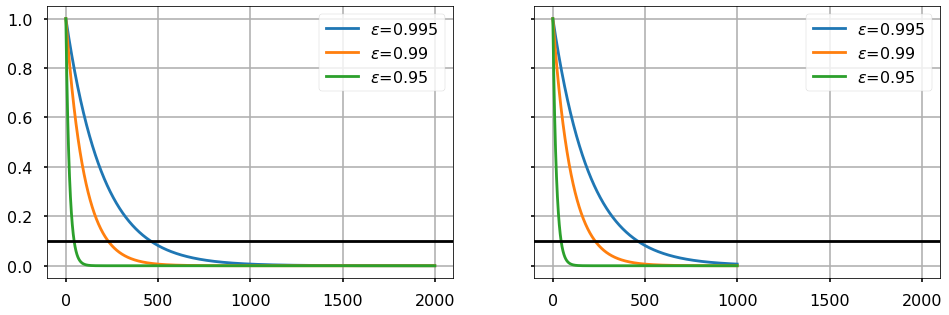

In [139]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16, 5))
eps1, eps2, eps3 = 0.995, 0.99, 0.95

ax1 = axs[0]
neps1 = np.arange(2000)

ax1.plot(1*eps1**neps1, label=rf'$\epsilon$={eps1}')
ax1.plot(1*eps2**neps1, label=rf'$\epsilon$={eps2}')
ax1.plot(1*eps3**neps1, label=rf'$\epsilon$={eps3}')

ax2 = axs[1]
neps2 = np.arange(1000)
ax2.plot(1*eps1**neps2, label=rf'$\epsilon$={eps1}')
ax2.plot(1*eps2**neps2, label=rf'$\epsilon$={eps2}')
ax2.plot(1*eps3**neps2, label=rf'$\epsilon$={eps3}')

for ax in axs:
    ax.grid()
    ax.axhline(0.1, color='black')
    ax.legend()

plt.show()

The chosen value of `eps_start` is 0.95, it gets below 0.1 (a good standard to converge) before epside 500

# Score by Agent

In [142]:
experiments= ['dqn:v01', 'doubledq:v01', 'dueldq:v01', 'dqn:v02']

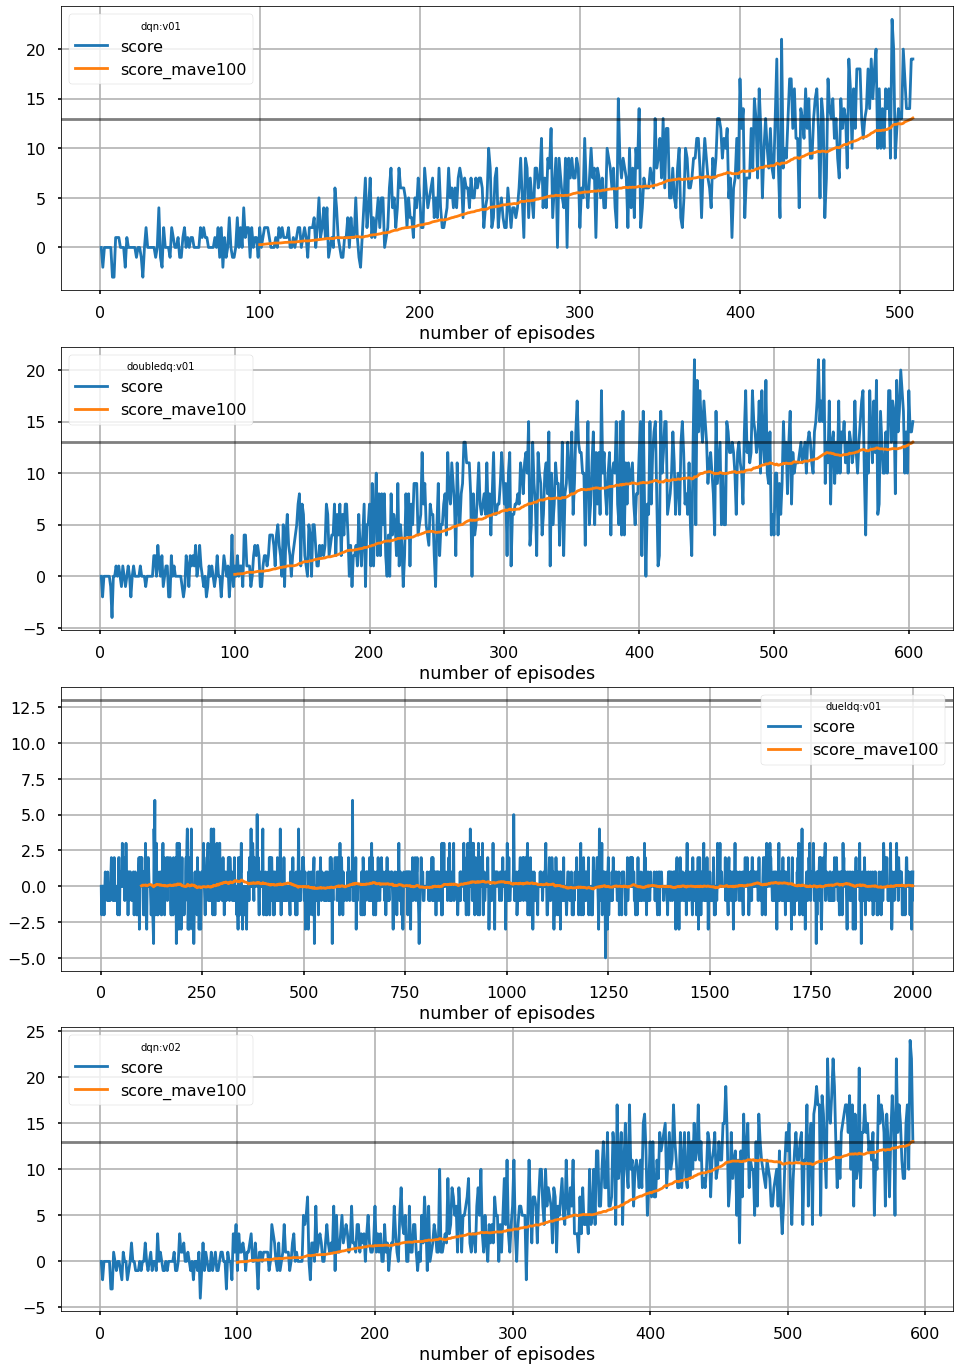

In [145]:
fig, axs = plt.subplots(len(experiments),1, figsize=(16,24))

for row_idx, ax in enumerate(axs):
    ax1 = axs[row_idx]
    experiment_name = experiments[row_idx]
    scores_df[scores_df['experiment']==experiment_name].plot(ax=ax)
    ax.axhline(13, color='black', alpha=0.5)
    ax.legend(title=experiment_name)
    ax.set_xlabel('number of episodes')
    ax.grid()

plt.show()


# Discussion

Every agent/model is trained with the same set of hyperparameters. Neural nets have 2 layers of 64 and 32 units, which seems a good trade-off between complexity and fitting time. An alternative architecture that adds dropout layers is also included

The best agent/model seems to be `regular dqn` (with fixed td-target) as it solves the environmnet at episode 500. Double dqn also solves the environment a little later. However, Dueling dqn does not converge at all.

`Double q-net`, in theory, avoids overestimation of TD-Targets, however, its results are sightly worse than regular dqn, this may be to weight soft updating or than this overestimation effect is so important in this set up.

`Duel q-net` does not converge, this may be due that by splitting V(S) and A(S,A) in this particular environment is not a good step; in fact V(S) will depend on banana's distribution and this changes over time. In addition, there should be some randomness in banana generation, therefore, there may not a priveledged set of S and thus duel q-net is not a good arquitechture

Finally, `prioritized experience replay` is not implemented due its additional complexity, in addition, there are not scare or expensive transitions that justify this implementation

**Further steps:**

A more detailed hyperparamenter tunning in network architecture may yield better results, adding regularization with dropout layers does not improve convergence, therefore, it seems that [64, 32] does not overfit; fitting a more complex model (with some regularization) may benefit the agent

In additon, as it only takes 500 epsidoes and $\epsilon$ reaches 0.1 slightly before, a lower `eps_start`=-99 may be a good idea

